In [36]:
import numpy as np
import src.EP_model as EP_model
from tqdm import tqdm
import src.utils as utils
from tqdm import tqdm
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
#%matplotlib ipympl
#%matplotlib widget
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
folder_name = './results/104_2025-05-05T23:06_MNIST_1000_step_test_b8/'
epoch_idx = 19
ep_model = EP_model.EP_model()
ep_model = utils.load_obj(f'{folder_name}/ep_model.pkl')

ep_model.N_neal_temps = ep_model.N_rev_neal_temps = 2
ep_model.N_neal_steps = ep_model.N_rev_neal_steps = 1

ep_model.create_schedule()
ep_model.load_trained_param(f'{folder_name}/2', best_epoch=epoch_idx)
x_train, y_train, y_train_idx, x_val, y_val, y_val_idx = utils.load_data('./data/MNIST_1000')


In [185]:
print((y_train_idx==0).sum())

110


In [212]:
num_test = 500
c2c3 = np.zeros(num_test)
c2w3 = np.zeros(num_test)
w2c3 = np.zeros(num_test)
w2w3 = np.zeros(num_test)

for j in tqdm(range(num_test)):
    tmp = utils.convert_to_jijDense(ep_model.J, ep_model.H)
    for idx in range(1000):
        x = x_train[idx]
        y = y_train[idx]
        truth = y_train_idx[idx]

        lattice = tmp.gen_spin()
        ep_model.N_neal_temps = ep_model.N_rev_neal_temps = 2
        ep_model.create_schedule()
        config = ep_model._forward_single(x.flatten(), lattice=lattice)
        pred1 = ep_model.label_to_num(config[ep_model.ising_out_idx][None, :])[0]

        ep_model.N_neal_temps = ep_model.N_rev_neal_temps = 3
        ep_model.create_schedule()
        config2 = ep_model._forward_single(x.flatten(), lattice=lattice)
        pred2 = ep_model.label_to_num(config2[ep_model.ising_out_idx][None, :])[0]

        if pred1 == truth and pred2 == truth:
            c2c3[j]+=1
        elif pred1 == truth and pred2 != truth:
            c2w3[j] += 1
        elif pred1 != truth and pred2 == truth:
            w2c3[j]+=1
        else:
            w2w3[j] += 1

        # images = [x, config[ep_model.ising_hidden_idx].reshape(8,8), config[ep_model.ising_out_idx].reshape(10,4)]
        # images += [x, config2[ep_model.ising_hidden_idx].reshape(8,8), config2[ep_model.ising_out_idx].reshape(10,4)]
        # titles = ['input spins\n(clamped with inf ext field)', 'hidden layer', 'output layer']
        # titles += ['input spins\n(clamped with inf ext field)', 'hidden layer', 'output layer']
        # x_tickss = [np.arange(0, 14, 2), np.arange(0, 8, 2), np.arange(0, 4, 2)]
        # y_tickss = [np.arange(0, 14, 2), np.arange(0, 8, 2), np.arange(0, 10, 1)]

        # layout = [[0,1,2], [3,4,5]]
        # fig, ax = plt.subplot_mosaic(layout, figsize=(9,7))

        # for i in range(len(images)):
        #     ax[i].imshow(images[i])
        #     ax[i].set_title(titles[i])
        #     if i < 3:
        #         ax[i].set_xticks(x_tickss[i])
        # plt.show()


100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


In [214]:
# print(c2c3)
# print(c2w3)
# print(w2c3)
# print(w2w3)
print(np.mean(c2c3 + c2w3)/1000*100)
print(np.std(c2c3 + c2w3)*2/np.sqrt(num_test)/1000*100)
print(np.mean(c2c3 + w2c3)/1000*100)
print(np.std(c2c3 + w2c3)*2/np.sqrt(num_test)/1000*100)


50.491200000000006
0.1046916447478021
56.572199999999995
0.07857160606733198


In [205]:
print((w2c3 + c2c3)/100000)
print((c2w3 + c2c3)/100000)

0.56772
0.50588


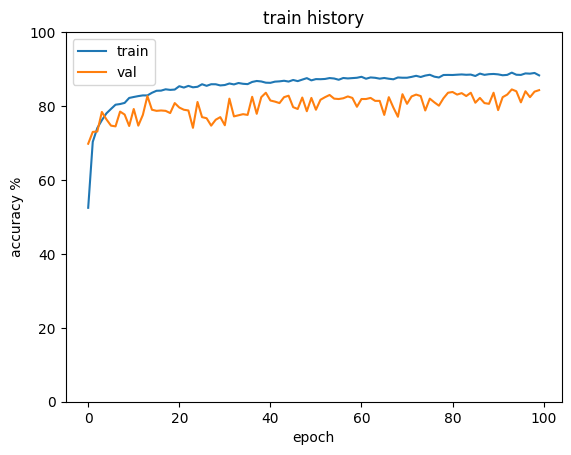

In [30]:
hist = np.load(f'{folder_name}/acc_history.npy')
plt.plot(np.arange(len(hist)), hist[:, 0]*100, label='train')
plt.plot(np.arange(len(hist)), hist[:, 1]*100, label='val')
plt.legend()
plt.ylabel('accuracy %')
plt.xlabel('epoch')
plt.title('train history')
plt.ylim(0, 100)
plt.savefig(f'./hi.png')